## Name: Jessy Song


## 📡 Downloading the Data
For this assignment, we will be working with the [SKM-TEA](https://arxiv.org/abs/2203.06823) dataset (Desai et al, NeurIPS 2021), which includes raw k-space MRI data as well image segmentation and detection labels. Let's download a [mini version](https://huggingface.co/datasets/arjundd/skm-tea-mini) of the SKM-TEA dataset from Huggingface. This mini dataset was created for building demos/tutorials with the SKM-TEA dataset.

*NOTE*: This download process can take ~5-10 minutes.

In [ ]:
import os
from tqdm import tqdm

dataset_dir = "skm-tea/v1-release"
url = "https://huggingface.co/datasets/arjundd/skm-tea-mini/resolve/main/v1-release"
force_download = False


if force_download:
  !rm -rf $dataset_dir

if not os.path.isdir(dataset_dir):
  os.makedirs(dataset_dir)
  for fname in ["all_metadata.csv", "annotations/v1.0.0/train.json", "annotations/v1.0.0/val.json", "annotations/v1.0.0/test.json"]:
    out = f"{dataset_dir}/{fname}"
    os.makedirs(os.path.dirname(out), exist_ok=True)
    !wget -q $url/$fname -O $out


  for fname in tqdm(["dicoms", "files_recon_calib-24", "image_files", "segmentation_masks"], disable=False):
    !wget -c $url/"tarball"/$fname".tar.gz" -O - | tar -xz -C $dataset_dir/


## 🚧 Setup
Lets install the SKM-TEA Python library to make data loading and management easier

In [ ]:
!pip install --upgrade pytorch-lightning==1.7.7 meddlr==0.0.9 torchmetrics==0.11.4 skm-tea cupy-cuda12x

Let's import the libraries that we will need for this homework assignment


In [ ]:
## PROVIDED

import os
os.environ["MEDDLR_DATASETS_DIR"] = "./"

from pprint import pprint

import numpy as np
import torch
import h5py
import matplotlib.pyplot as plt
import dosma as dm
import pydicom as dcm

import meddlr.ops as oF
from meddlr.data import DatasetCatalog, MetadataCatalog
from meddlr.utils.logger import setup_logger
from meddlr.utils import env

import skm_tea as st

# Suppress printing warnings about visualization and some divide by 0 issues
import warnings
warnings.filterwarnings('ignore')

Great, we're ready to rock and roll! Let's start by exploring the dataset that we previously download. With the `DatasetCatalog.get("skmtea_v1_train")` command below, we are loading the SKM-TEA Mini training dataset, which contains a list named `dataset_dicts`, where each list element (e.g. `scan`) is a dictionary that corresponds to all the data that we have per subject.

Notice that `scan` contains descriptive information about the MRI volume (`matrix_shape`, `num_coils`, etc), as well as raw and reconstructed data (`*.nii.gz` and `h5` files).

In [ ]:
## PROVIDED

# Load list of dictionaries for the SKM-TEA v1 training dataset.
dataset_dicts = DatasetCatalog.get("skmtea_v1_train")
scan = dataset_dicts[0]
pprint(scan)

{'dicom_dir': './skm-tea/v1-release/dicoms/MTR_201',
 'dicom_mask_file': './skm-tea/v1-release/segmentation_masks/dicom-track/MTR_201.nii.gz',
 'file_name': 'MTR_201.h5',
 'gw_corr_mask_file': './skm-tea/v1-release/segmentation_masks/raw-data-track/MTR_201.nii.gz',
 'id': 1,
 'image_file': './skm-tea/v1-release/image_files/MTR_201.h5',
 'inspected': True,
 'matrix_shape': [512, 512, 160],
 'num_coils': 8,
 'num_echoes': 2,
 'orientation': ['SI', 'AP', 'LR'],
 'recon_file': './skm-tea/v1-release/files_recon_calib-24/MTR_201.h5',
 'scan_id': 'MTR_201',
 'subject_id': 225,
 'timepoint': 0,
 'voxel_spacing': [0.3125, 0.3125, 0.8]}



Since the resolution of our scan (`voxel_spacing`) is anisotropic, when we use matplotlib to visualize these scans, the aspect ratio gets distorted since it assumes isotropic voxels. So we have to retrospectively correct for this. We define this `ASPECT` constant for visualization purposes. For looks only!




In [ ]:
ASPECT = 0.390625

The variable `scan` is a data dictionary that consists of the k-space data for the MRI scan, the reconstructed images, segmentation masks, and additional image headers. The following dictionary keys will be relevant for the homework:

`kspace`: k-space data for the MRI scan

`target`: reconstructed images for the MRI scan

`gw_corr_mask_file`: ground-truth segmentation mask for the MRI scan

Note that the k-space file is very large, and for this homework, we will only use a single slice. Lets load slice number 256 and echo number 0 for a majority of the homework. Lets output the dimensions of our dataset, though.

In [ ]:
## PROVIDED

# Reconstruction data
recon_file = scan["recon_file"]

SLICE_NUM = 256
ECHO_NUM = 0

with h5py.File(recon_file, "r") as f:

    # f["kspace"] is a 5D array.
    # We can load different data slices and also query the array shape

    kspace = f["kspace"][SLICE_NUM, :, :, ECHO_NUM, :]
    xres, yres, zres, num_echoes, num_coils = f["kspace"].shape

print(f'Image dimensions: Slice = {xres}, Y-Res = {yres}, Z-Res = {zres}, Echoes = {num_echoes}, Coils = {num_coils}')
print(f'Please keep this dimension terminology in mind for future questions!')

Image dimensions: Slice = 512, Y-Res = 512, Z-Res = 160, Echoes = 2, Coils = 8
Please keep this dimension terminology in mind for future questions!


#1: Data I/O (7 points)


###1a: Plotting data

a. Plot k-space data from all the coils *(for the same slice_num = 256 and echo_num = 0)*. Please use *cmap = 'gray'* for all imaging visualizations of k-space and the anatomy. Note that k-space data is complex (has a real and imaginary component). Plot the absolute value. (1pt). Try plotting the same data with log-transformation. [Hint: due to the scaling of the log-transformed data, try visualizing with the following parameters for plt.imshow: *"vmin = 12, vmax = 25"*. What do you see? (1pt)


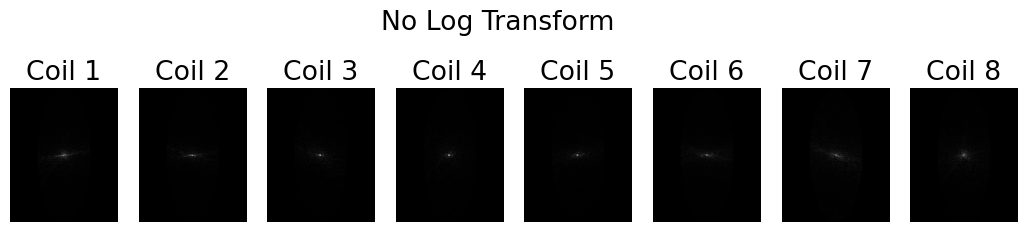

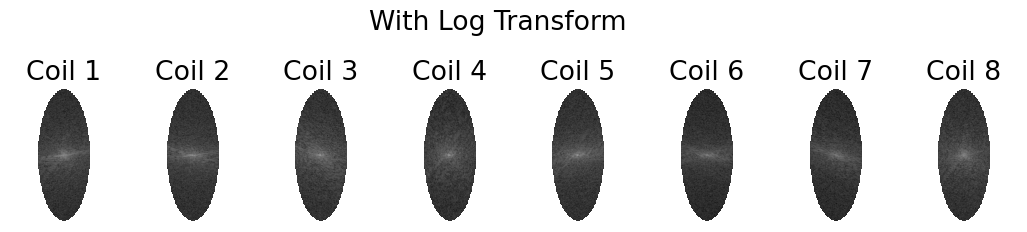

In [ ]:
_, axs = plt.subplots(1, num_coils, figsize=(13,3))

## WITHOUT LOG TRANSFORM
plt.suptitle('No Log Transform')
for idx in range(num_coils):
    plt.subplot(1, num_coils, idx+1)
    plt.imshow(np.abs(kspace[:,:,idx]), cmap="gray", aspect=ASPECT)
    plt.axis('off')
    plt.title(f'Coil {idx+1}')

plt.show()
plt.close()

## WITH LOG TRANSFORM
_, axs = plt.subplots(1, num_coils, figsize=(13,3))

plt.suptitle('With Log Transform')
for idx in range(num_coils):
    # TODO: Your code here
    plt.subplot(1, num_coils, idx+1)
    plt.imshow(np.log(np.abs(kspace[:,:,idx])), cmap="gray", aspect=ASPECT, vmin=12, vmax=25)
    plt.axis('off')
    plt.title(f'Coil {idx+1}')

plt.show()
plt.close()

We can see that after log transformation, the k-space data at each coils is visualized as an elliptical shape. The frequency is higher around the center of the images, and the difference in the spatial frequency of the kspace data are visualized more clearly with the log transformation.

###1b. Reconstructing images

Reconstruct the images by transforming them from the k-space domain to the image domain using numpy's inverse fast Fourier transform (2D): *ifft2*. Plot the absolute value of resulting images per coil (1pt). Note: You may want to export using the np.fft.fftshift to correctly tile the image.

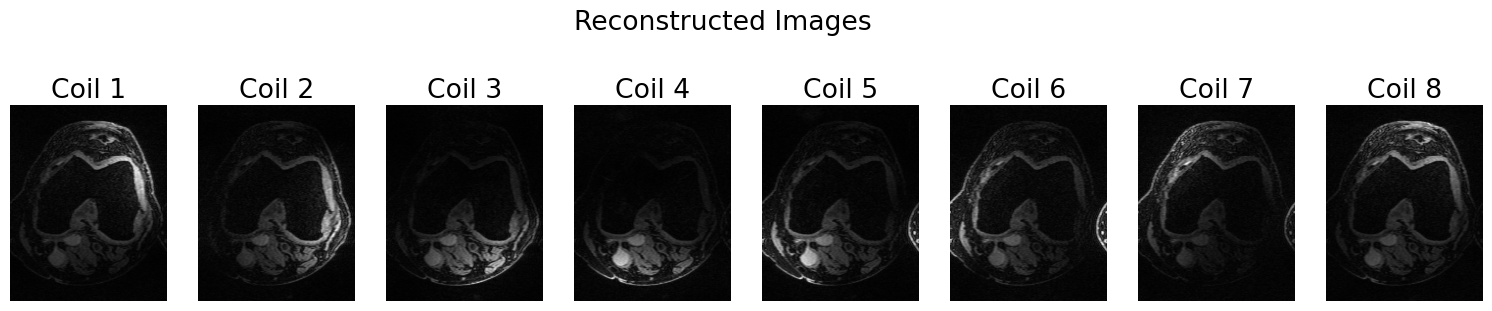

In [ ]:
# To create reconstructed image, we have to take the FFT2 of every k-space coil image
# This is achieved using np.fftshift(np.fft.ifft2(<KSPACE_COIL>))

_, axs = plt.subplots(1, num_coils, figsize=(19,4))

plt.suptitle('Reconstructed Images')
for idx in range(num_coils):
    # TODO: Your code here
    plt.subplot(1, num_coils, idx+1)
    # print(np.fft.ifft2(kspace[:,:,idx]))
    # plt.imshow(np.abs(np.fft.ifft2(kspace[:,:,idx])), cmap="gray", aspect=ASPECT)
    plt.imshow(np.abs(np.fft.fftshift(np.fft.ifft2(kspace[:,:,idx]))), cmap="gray", aspect=ASPECT)
    plt.axis('off')
    plt.title(f'Coil {idx+1}')

plt.show()
plt.close()

In [ ]:
np.abs(np.fft.ifft2(kspace[:,:,0])).shape

(512, 160)

###1c. Coil combination

Radiologists do not visualize images from each coil separately. That would only depicts parts of the anatomy! Take your multi-coil image reconstructions and combine them across coils using a root sum of squares across coils approach. (1pt).

$ RSOS(x) = \sqrt{|\sum x^2|}$

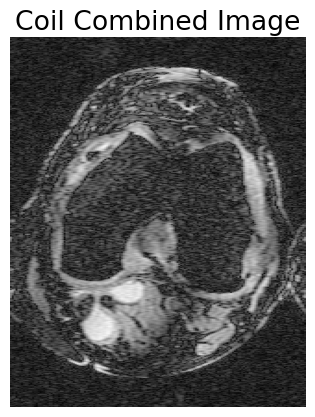

In [ ]:
# Here, we create an array to store each FFT2 transformed image
# Then, we perform a root sum of squares across the coil dimension for this array

# Pre-allocate memory for coil-wise images
mc_image = np.zeros((8, 512, 160))

for idx in range(num_coils):
    # TODO: Your code here
    mc_image[idx] = np.fft.fftshift(np.fft.ifft2(kspace[:,:,idx]))

# RSOS Image: Sqrt of each pixel value squared and summed across the coil dimension
# TODO: Your code here
rsos_img = np.sqrt(np.abs(np.sum(mc_image, axis=0)))

plt.imshow(rsos_img, cmap = 'gray', aspect = ASPECT)
plt.title('Coil Combined Image')
plt.axis('off')
plt.show()
plt.close()

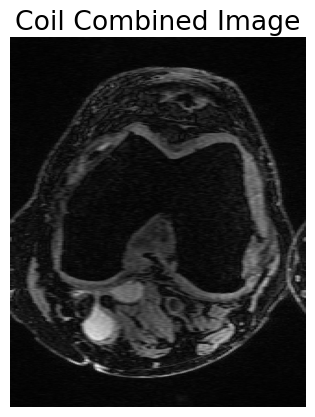

In [ ]:
# Here, we create an array to store each FFT2 transformed image
# Then, we perform a root sum of squares across the coil dimension for this array

# Pre-allocate memory for coil-wise images
mc_image = np.zeros((8, 512, 160))

for idx in range(num_coils):
    # TODO: Your code here (hint: use 1b)
    mc_image[idx] = np.fft.fftshift(np.fft.ifft2(kspace[:,:,idx]))

# RSOS Image: Sqrt of each pixel value squared and summed across the coil dimension
# TODO: Your code here
rsos_img = np.sqrt(np.abs(np.sum(np.power(mc_image, 2), axis=0)))

plt.imshow(rsos_img, cmap = 'gray', aspect = ASPECT)
plt.title('Coil Combined Image')
plt.axis('off')
plt.show()
plt.close()

In [ ]:
rsos_img.shape

(512, 160)

###1d. 3D Recon and visualization

Now that you have your reconstructions working for a single slice, let's perform slice-by-slice reconstruction across the entire volume of slices. We had initially only loaded a single slice from the k-space h5py array, but now we will now have to account for all slices. First, create a function `recon_slice` that takes as input multi-coil k-space and outputs a reconstructed slice. Use the code from 1b and 1c above, wrapped into a function call (1pt).

You may ask how to contend with 3D voxels in this dataset. For convenience, the k-spce data is stored in a format of [*x, ky, kz*] meaning that the x-dimension is IFFT2 transformed already, but *y* and *z* are not (hence the k that precedes). Taking successive 2D Fourier tranforms along the *x* dimension should do the trick here. It should take ~1min to reconstructed all slices.


Once you have done this, plot the center slice from the axial, sagittal, and coronal orientations. Note that you may want to refer to a knee MRI atlas to get a bearing of the anatomy. Please also plot the images with the standard MRI orientations: Axial - anterior is up, posterior is down; Sagittal - anterior is left, posterior is right.

For improved visualization, the `ASPECT` constant for visualization for sagittal slices should be 1 and for coronal slices should be the same `ASPECT` constant (1pt).

In [ ]:
## PROVIDED
def recon_slice(kspace_slice):
    """Reconstruct multi-coil kspace data and return sum of squares combination"""
    # INPUTS:
    # [yres, zres, ncoils]: Multi-coil k-space input per slice
    # OUTPUTS:
    # [yres, zres]: Root sum of squares reconstructed slice

    # Do Recon
    # TODO: Your code here (hint: use 1c)
    mc_image = np.zeros(kspace_slice.shape)
    num_coils = kspace_slice.shape[2]

    for idx in range(num_coils):
        # TODO: Your code here (hint: use 1b)
        mc_image[:,:,idx] = np.fft.fftshift(np.fft.ifft2(kspace_slice[:,:,idx]))

    # RSOS Image: Sqrt of each pixel value squared and summed across the coil dimension
    rsos_img =  np.sqrt(np.abs(np.sum(np.power(mc_image, 2), axis=2)))

    return rsos_img

In [ ]:
with h5py.File(recon_file, "r") as f:
    kspace_recon = np.zeros(f["kspace"].shape[:4])
    print(kspace_recon.shape)
    # f["kspace"] is a 5D array.
    # We can load different data slices and also query the array shape
    for i_slice in range(f["kspace"].shape[0]):
      for echo in range(f["kspace"].shape[3]):
        kspace_recon[i_slice,:,:,echo] = recon_slice(f['kspace'][i_slice, :, :, echo, :])
    print(kspace_recon.shape)
    # xres, yres, zres, num_echoes, num_coils = f["kspace"].shape

(512, 512, 160, 2)
(512, 512, 160, 2)


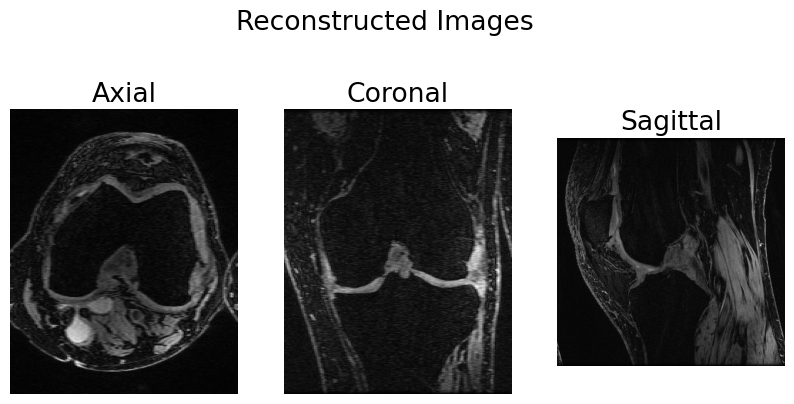

In [ ]:
## PLOT CENTER SLICES FROM THE IMAGING VOLUME

_, axs = plt.subplots(1, 3, figsize=(10,5))
plt.suptitle('Reconstructed Images')

# Plot center slices by using the floor division operator (res//2)
# on the appropriate dimension of full_img

plt.subplot(1, 3, 1)
# TODO: Your code here

x_size, y_size, z_size, echo_size = kspace_recon.shape

plt.imshow(kspace_recon[x_size//2,:,:,0], cmap = 'gray', aspect = ASPECT)
plt.axis('off')
plt.title(f'Axial')

plt.subplot(1, 3, 2)
# TODO: Your code here
plt.imshow(kspace_recon[:,y_size//2,:,0], cmap = 'gray', aspect = ASPECT)
plt.axis('off')
plt.title(f'Coronal')

plt.subplot(1, 3, 3)
# TODO: Your code here
plt.imshow(kspace_recon[:,:,z_size//2,0], cmap = 'gray', aspect = 1)
plt.axis('off')
plt.title(f'Sagittal')
plt.show()
plt.close()

###1e. Image contrasts

Describe the contrasts in the image. The tissues that most radiologists evaluate are the bone and cartilage. Skeletal muscle also accounts for a large volume. Qualitatively describe how these three tissues appear in the multi-planar images you plotted above (1pt).

Extra Credit: Upload an image where all the visible bone and cartilage surfaces are annotated and pointed out with arrows (1pt).

The bones (femur, tibia, patella) appears as the darkest regions from all images. The femur and tibia are separated by the meniscus cartilage, shown as the triangular white area between the bones on coronal plane image. The normal meniscus areas should be relatively dark on MRI, but in this image we can see there is slight tear, hence shows a lighter color on the MRI. The patellar (bone and ligament between it) is visible from the sagittal plane, with the patellar bone being darker than the ligaments around it (top and bottom of it from sagittal view). Muscles (more visible on sagittal image) are lighter in color, having some grey area in between.



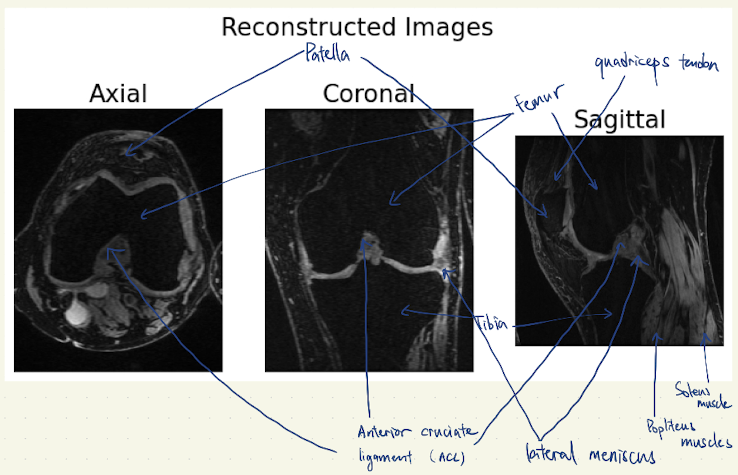

# 2: Image Manupulation (8 points)


###2a. Low-pass filter mask creation
a. Create a low-pass filtered version of slice 256 from the example in question 1. The low frequencies are at the center of the image while the frequencies increase the further away you go from the center.

First, create a binary mask that consists of all the sampled k-space data (sampled data will have non-zero frequency). Then create a low-pass version of the mask that consists of ~6-7% of those sampled points (for an undersampling rate of 15x); these points should be at the center of the image. What percentage of the original frequencies did you use? Plot the original sampling mask and your low-pass filtered mask side-by-side (1pt)

Original k-space points = 31576.0.
Low pass filtered k-space points = 2184.0.
Total sampled points = 6.9%


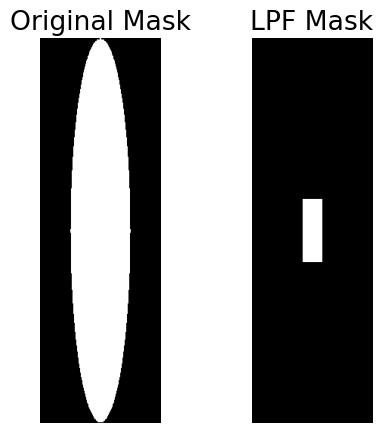

In [ ]:
## PROVIDED

## helpful repo: https://pypi.org/project/mrina/
# TODO: Your code here
kspace_nums = np.abs(np.sum(kspace, axis=2))
kspace_mask = np.ma.array(kspace_nums)
kspace_mask[kspace_mask.nonzero()]=1

## approximate the sampled area to a rectangle size, while keeping ratio of the slice
## y_sampled*z_sampled=area, z_sampled=(zres/yres)*y_sampled, y_sampled^2*(zres/yres) = area
area = (kspace_mask==1).sum()
y_sampled = round(np.sqrt(area/(zres/yres)))
z_sampled = round(y_sampled*(zres/yres))

## we try to find the lpf_axis_sample_rate from: (lpf_axis_sample_rate)^2 * (y_sampled*z_sampled) = 0.07*(y_sampled*z_sampled)
## which get lpf_axis_sample_rate = sqrt(0.07)
sampled_y_radius = round((y_sampled*np.sqrt(0.07))//2)
lpf_y_idx = (yres//2-sampled_y_radius, yres//2+sampled_y_radius)
sampled_z_radius = round((z_sampled*np.sqrt(0.07))//2)
lpf_z_idx = (zres//2-sampled_z_radius, zres//2+sampled_z_radius)

lpf_mask = np.zeros((yres, zres))
lpf_mask[lpf_y_idx[0]:lpf_y_idx[1], lpf_z_idx[0]:lpf_z_idx[1]] = 1

print(f'Original k-space points = {np.sum(kspace_mask)}.')
print(f'Low pass filtered k-space points = {np.sum(lpf_mask)}.')
print(f'Total sampled points = {100*np.sum(lpf_mask)/np.sum(kspace_mask):.1f}%')

# Visualize the created mask vs the original

_, axs = plt.subplots(1, 2, figsize=(5,5))

plt.subplot(1, 2, 1)
plt.imshow(kspace_mask, cmap = 'gray')
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lpf_mask, cmap = 'gray')
plt.title('LPF Mask')
plt.axis('off')
plt.show()
plt.close()

###2b. Low-pass filter image recon

Now use the low pass filtered mask and multiply it with the original k-space (note that you will have to do this across the coil dimension also since all coils are undersampled). Multiplying this undersampling mask with the actually collected data will simulate what a faster acquisition would have been. Using this simulated low pass filtered kspace data, reconstruct the resulting images.

Plot the original, low pass filtered k-space reconstructed images, and a difference between the two. You may want to scale the difference image by a factor of 5-10x to visualize the differences more clearly (1pt). Describe what you see (1pt).

In [ ]:
lpf_mask_coildim = np.tile(lpf_mask, (num_coils,1,1))
lpf_mask_coildim = np.transpose(lpf_mask_coildim, axes=(1, 2, 0)).shape

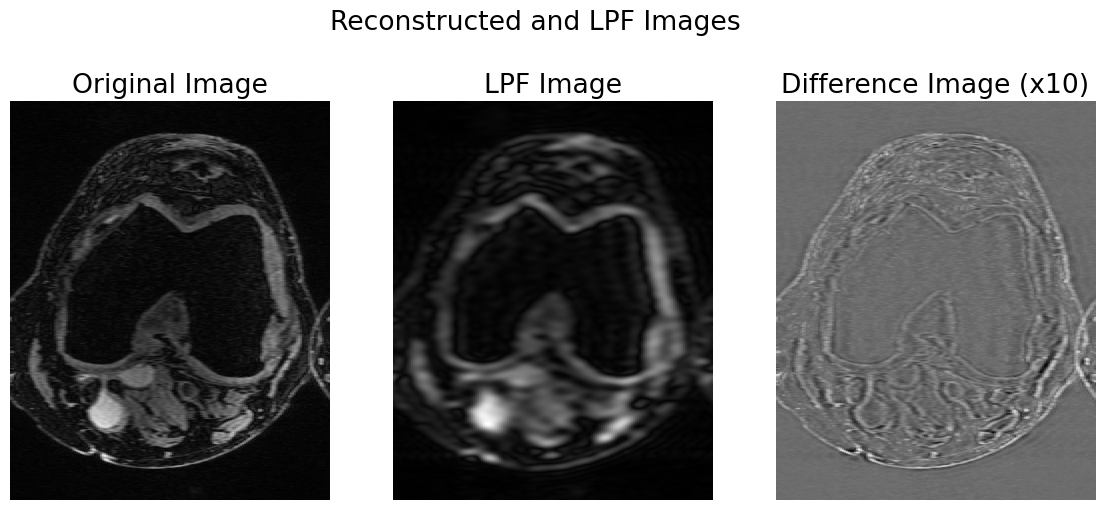

In [ ]:
# Create low-pass filtered k-Space

# We have created a 2D mask for undersampling.
# We need to make sure it has the same dimensions as the k-space data (across coils)
# Hint: Use np.tile
# TODO: Your code here
lpf_mask_coildim = np.tile(lpf_mask, (num_coils,1,1))
lpf_mask_coildim = np.transpose(lpf_mask_coildim, axes=(1, 2, 0))

# Undersample the kspace by multiplying it with the mask
lpf_kspace = lpf_mask_coildim * kspace
lpf_image = recon_slice(lpf_kspace)

_, axs = plt.subplots(1, 3, figsize=(14,6))
plt.suptitle('Reconstructed and LPF Images')

# Visualize the two sets of images and plot 10x their difference
lpf_diff_scalar = 10

plt.subplot(1, 3, 1)
plt.imshow(rsos_img, cmap = 'gray', aspect = ASPECT)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lpf_image, cmap = 'gray', aspect = ASPECT)
plt.title('LPF Image')
plt.axis('off')

plt.subplot(1, 3, 3)
# TODO: Your code here
plt.imshow((rsos_img-lpf_image)*lpf_diff_scalar, cmap = 'gray', aspect = ASPECT)
plt.title(f'Difference Image (x{lpf_diff_scalar})')
plt.axis('off')

plt.show()
plt.close()

We can see that the LPF image is more blurry, and areas with high contrast in the original image (the edges between dark and light areas) are being extracted out by the LPF. This outline of the original image is visualized in the difference image.

###2c. High-pass filter mask creation.

Create a high-pass filtered version of slice 256 from the example in question 1. Similar as above, create a mask that consists of all the sampled k-space data and then a high-pass version of mask that consists of ~75% of those sampled points. Plot the original sampling mask and your high-pass filtered mask side-by-side (1pt). What percentage of the original frequencies did you use?

Original k-space points = 31576.0.
High pass filtered k-space points = 23992.0.
Total sampled points = 76.0%


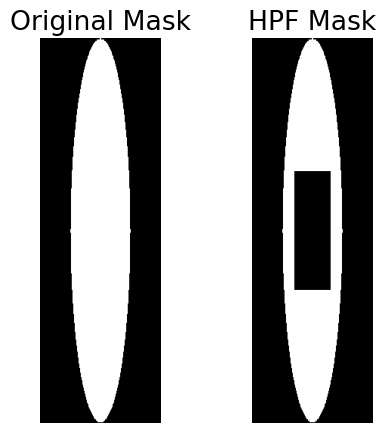

In [ ]:
## PROVIDED

# TODO: Your code here
sampled_y_radius = round((y_sampled*np.sqrt(0.25))//2)
hpf_y_idx = (yres//2-sampled_y_radius, yres//2+sampled_y_radius)
sampled_z_radius = round((z_sampled*np.sqrt(0.25))//2)
hpf_z_idx = (zres//2-sampled_z_radius, zres//2+sampled_z_radius)

hpf_mask = np.ones((yres, zres))
hpf_mask[hpf_y_idx[0]:hpf_y_idx[1], hpf_z_idx[0]:hpf_z_idx[1]] = 0
hpf_mask = hpf_mask * kspace_mask

print(f'Original k-space points = {np.sum(kspace_mask)}.')
print(f'High pass filtered k-space points = {np.sum(hpf_mask)}.')
print(f'Total sampled points = {100*np.sum(hpf_mask)/np.sum(kspace_mask):.1f}%')

# Visualize the created mask vs the original

_, axs = plt.subplots(1, 2, figsize=(5,5))

plt.subplot(1, 2, 1)
plt.imshow(kspace_mask, cmap = 'gray')
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hpf_mask, cmap = 'gray')
plt.title('HPF Mask')
plt.axis('off')
plt.show()
plt.close()

###2d. High-pass filter image recon
 Now use the high pass filtered mask and multiply it with the original k-space (note that you will have to do this across the coil dimension also since all coils are undersampled). Using this simulated high pass filtered k-space data, reconstruct the resulting images.

Plot the original, high pass filtered k-space reconstructed images, and a difference between the two. You may want to scale the difference image by a factor of 5-10x to visualize the differences more clearly (1pt). Describe what you see (1pt).

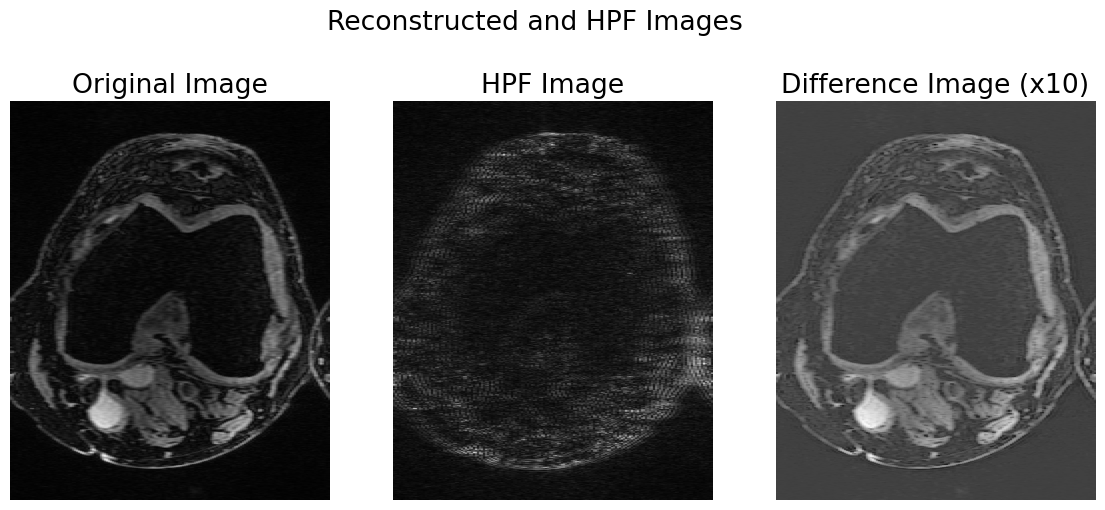

In [ ]:
# Create high-pass filtered k-Space

# We have created a 2D mask for undersampling.
# We need to make sure it has the same dimensions as the k-space data (across coils)
# Hint: Use np.tile
# TODO: Your code here
hpf_mask_coildim = np.tile(hpf_mask, (num_coils,1,1))
hpf_mask_coildim = np.transpose(hpf_mask_coildim, axes=(1, 2, 0))

# Undersample the kspace by multiplying it with the mask
hpf_kspace = hpf_mask_coildim * kspace
hpf_image = recon_slice(hpf_kspace)

_, axs = plt.subplots(1, 3, figsize=(14,6))
plt.suptitle('Reconstructed and HPF Images')

# Visualize the two sets of images and plot 10x their difference
hpf_diff_scalar = 10

plt.subplot(1, 3, 1)
plt.imshow(rsos_img, cmap = 'gray', aspect = ASPECT)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(hpf_image, cmap = 'gray', aspect = ASPECT)
plt.title('HPF Image')
plt.axis('off')

plt.subplot(1, 3, 3)
# TODO: Your code here
plt.imshow((rsos_img-hpf_image)*hpf_diff_scalar, cmap = 'gray', aspect = ASPECT)
plt.title(f'Difference Image (x{hpf_diff_scalar})')
plt.axis('off')

plt.show()
plt.close()

We can see that after HPF, the image with high contrast areas are being emphasized, and that the areas with high brightness/change in contrast are kept in the HPF imgae. However, this loses information on image areas where the color is continuous, hence the difference in image shows the general image contrast regions clearer.

###2e. Additional noise simulation

Simulate the impact of adding Gaussian noise on the final reconstructed root sum of squares image. Use 4 levels of noise starting from minimal noise that only slightly affects the image till a level where almost all the underlying anatomy is obscured. Plot the images side by side (1pt).

Note that you will have to scale the random noise to the scale of the images. You can either scale the noise to match the image or scale the image for all pixel values to have a maximum value of 1. Describe the images and report all parameters used for the Gaussian noise addition. (1pt)

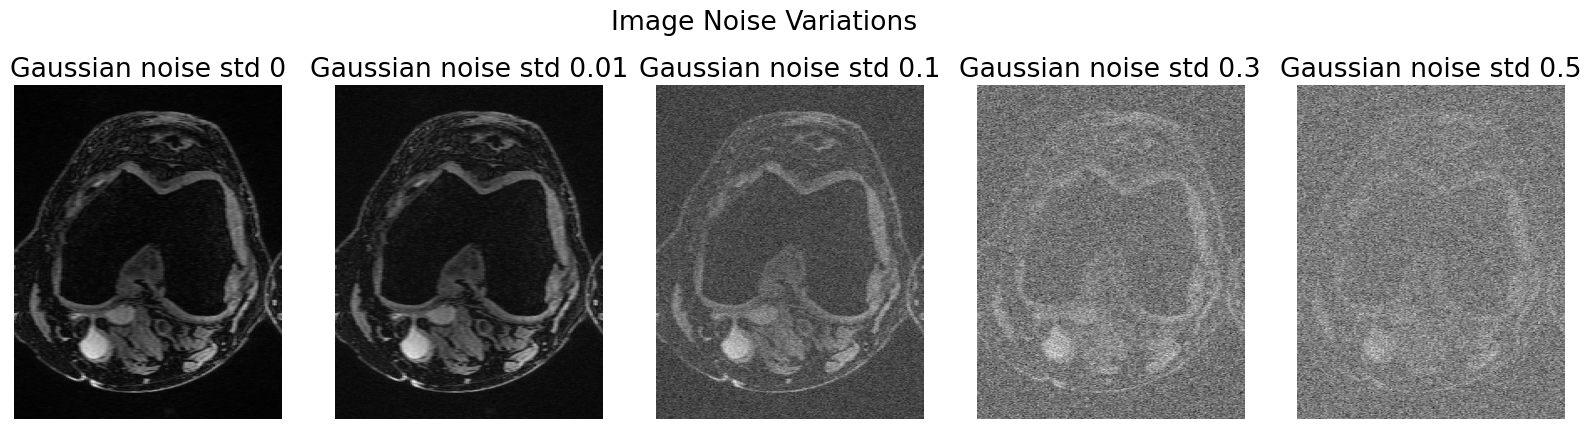

In [ ]:
# Creating Gaussian noise std values
noise_std_vals = [0,0.01,0.1,0.3,0.5]

# Scaling image to have a max value of 1
# TODO: Your code here
scale_img = rsos_img/rsos_img.max()

_, axs = plt.subplots(1, len(noise_std_vals), figsize=(20,5))
plt.suptitle(f'Image Noise Variations')

for noise_idx, noise_std in enumerate(noise_std_vals):

    # Creating different amounts of image noise
    # TODO: Your code here
    gauss_noise = np.random.normal(0, noise_std, size = scale_img.shape)
    noisy_img = scale_img + gauss_noise

    # Plotting scaled image + noise
    plt.subplot(1, len(noise_std_vals), noise_idx + 1)
    plt.imshow(noisy_img, cmap = 'gray', aspect = ASPECT)
    plt.title(f'Gaussian noise std {noise_std}')
    plt.axis('off')

plt.show()
plt.close()

The noise are generated with mean of 0 and standard deviation used are: [0,0.01,0.1,0.3,0.5]. We can see that as gaussian noise std increases, the image becomes more blurry and noisy, and anatomical areas are harder to be identified as we increase noise. With a std lower than 0.1, it may be still possible to identify and analyze the image.

# 3: DICOM, Image Segmentation, and Robustness (8 points)

###3a. Exploring DICOMS

DICOM (Digital Imaging and Communications in Medicine) files are one of the most commonly used interoperable file formats for storing medical imaging data. Use the starter code provided below to load a sample DICOM file. Explore the contents of the DICOM and describe what information it contains. (1pt)

In [ ]:
## PROVIDED

dataset_dicts = DatasetCatalog.get("skmtea_v1_train")
scan = dataset_dicts[0]

filename = f'{scan["dicom_dir"]}/I161.dcm'
print(filename)
dcm_file = dcm.dcmread(filename)

./skm-tea/v1-release/dicoms/MTR_201/I161.dcm


In [ ]:
dcm_file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.374.6574342.4029248.14608.1497363273.641
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113619.6.374
(0002, 0013) Implementation Version Name         SH: '4-RFV1_V2.x86_64'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.0.060.714112.9.568.4908909.7569775.96426.9760237877.149
(0008, 0020) Study Date                

The metadata stores information not only about the image content itself (the pixel values), but also the information on the patient, physician, the setup of the scan (equipment, patient position), the study and metadata on the image, such as size and acquisition equipments. These help to identify any anomalies, follow-up on the patient info later, and helps to conduct analysis later.

###3b. Loading DICOM metadata

All metadata can be accessed from the loaded DICOM files using either the header name or the hex tags. For example, we can access the *Modality* of the DICOM file using the specific header, either with the name or hex code.

```
print(dcm_file[0x0008, 0x0060].value)
print(dcm_file.Modality)
print(dcm_file["Modality"].value)
```
Execute these commands. What do you see?

The important image data is stored in the *pixel_array* tag. Plot the image in this DICOM file (1pt). Unlike the k-space data above, DICOM data takes into account the anisotropic nature of the pixel spacing, so there is no additional scaling or aspect ratio changing needed. This should look like the sagittal image that you have plotted in 1d.

MR
MR
MR


Text(0.5, 1.0, 'DICOM image')

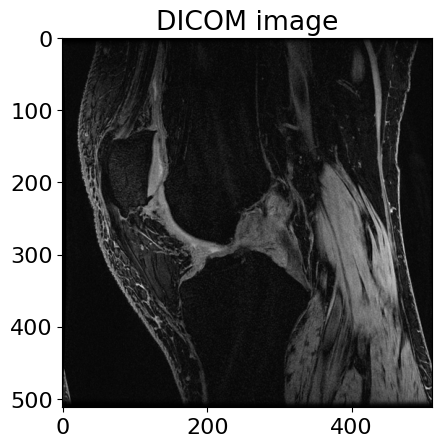

In [ ]:
print(dcm_file[0x0008, 0x0060].value)
print(dcm_file.Modality)
print(dcm_file["Modality"].value)

# Plot DICOM image
dcm_image = dcm_file.pixel_array

# TODO: Your code here
plt.imshow(dcm_image, cmap = 'gray')
plt.title(f'DICOM image')

###3c. Auto Segmentation

Now that we have the DICOM loaded, lets run some pre-trained segmentation models on this image. Run the cell below with some boilerplate code provided to run inference on a pretrainined knee MRI segmentation model. This code does the following:

1. Fetches pretrained model available on huggingface
2. Loads a slice of echo1 already stored in our data file (so results are consistent) and preprocesses it
3. Loads the original segmentation masks computed by a human
4. Runs automated segmentation model and converts outputs to human viewable format

In [ ]:
## PROVIDED
DCM_SLICE_NUM = 64  # the slice to segment

## -----------------------------------
# 3C1: FETCH MODEL FROM HUGGINGFACE
## -----------------------------------

model = st.get_model_from_zoo(
    cfg_or_file="https://huggingface.co/arjundd/skm-tea-models/raw/main/neurips2021/segmentation-models/U-Net_E1/config.yaml",
    weights_path="https://huggingface.co/arjundd/skm-tea-models/resolve/main/neurips2021/segmentation-models/U-Net_E1/model.ckpt",
).eval()

## -----------------------------------
## 3C2: LOAD SLICE FROM DICOM DATASET AND PREPROCESS IT
## -----------------------------------
from meddlr.data.data_utils import collect_mask

image_file = scan["image_file"]
with h5py.File(image_file, "r") as f:
    echo1_sl = f["echo1"][..., DCM_SLICE_NUM]  # Shape: (x, y, z)
    seg_sl = f["seg"][..., DCM_SLICE_NUM, :]  # Shape: (x, y, z, #classes)

# Converting to dimensions that are readable for the segmentation model
echo1_sl = torch.as_tensor(echo1_sl).unsqueeze(0).unsqueeze(0).float()  # Shape: (B, C, H, W)
# Pre-processing the data by making it zero mean and unit standard deviation
echo1_sl = (echo1_sl - echo1_sl.mean()) / echo1_sl.std()

## -----------------------------------
## 3C3: ORGANIZING THE SEGMENTATION
## -----------------------------------

# Ground truth segmentation for cartilage and meniscus
# Medial/lateral components are aggregated into the same category.
# 0 - patellar cartilage, 1 - femoral cartilage
# 2/3 - medial/lateral tibial cartilage, 4/5 - medial/lateral meniscus
gt_seg_sl = collect_mask(seg_sl, (0, 1, (2, 3), (4, 5)), out_channel_first=False)
gt_seg_sl = oF.one_hot_to_categorical(seg_sl, channel_dim=-1)

## -----------------------------------
## 3C4: RUNNING THE SEGMENTATION MODEL
## -----------------------------------

with torch.no_grad():
    logits = model({"image": echo1_sl})["sem_seg_logits"]

# Aggregating the outpits
pred = oF.pred_to_categorical(logits, activation='sigmoid').squeeze(0).numpy()

In [ ]:
## PROVIDED: SIMPLIFYING USER INTERFACE

# Here we will create a simple function that cleans up the above code
# Code will enable loading a slice from our dataset and outputting segmentations!

def segment_slice(img_slice):
    """Run segmentation model on 2D knee MRI data"""

    # INPUTS:
    # img_slice: [ xres, yres] - 2D sagittal image slice in xres x yres dimensions

    # OUTPUTS:
    # pred: [ xres, yres] - Categorical segmentation mask with following nomenclature:

    # Ground truth segmentation for cartilage and meniscus
    # Medial/lateral components are aggregated into the same category.
    # 0 - patellar cartilage, 1 - femoral cartilage
    # 2/3 - medial/lateral tibial cartilage, 4/5 - medial/lateral meniscus

    # Error checking
    if (np.ndim(img_slice) != 2):
        raise ValueError("Input image slie must be 2D!!!")

    # Converting to dimensions that are readable for the segmentation model
    img_slice = torch.as_tensor(img_slice).unsqueeze(0).unsqueeze(0).float()  # Shape: (B, C, H, W)
    # Pre-processing the data by making it zero mean and unit standard deviation
    img_slice = (img_slice - img_slice.mean()) / img_slice.std()

    with torch.no_grad():
        logits = model({"image": img_slice})["sem_seg_logits"]

    # Aggregating the outpits
    pred = oF.pred_to_categorical(logits, activation='sigmoid').squeeze(0).numpy()

    return pred

Phew! That's a lot of code, but we are now all set up! Plot the chosen DICOM image (echo 1 slice number 64), the automated segmentation, and the ground truth manual segmentations. (1pt). For the segmentations, use a colormap that is pleasing to you.

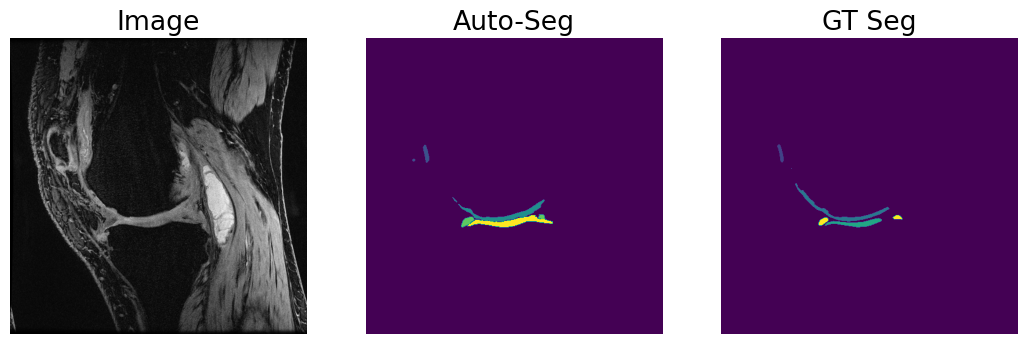

In [ ]:
# Loading image slice (hint: see 3C2)
# TODO: Your code here
with h5py.File(image_file, "r") as f:
    echo_img = f["echo1"][..., DCM_SLICE_NUM]  # Shape: (x, y, z)

# Segmenting image
segment_img = segment_slice(echo_img)

# Plotting
_, axs = plt.subplots(1, 3, figsize=(13,7))

plt.subplot(1, 3, 1)
plt.imshow(echo_img, cmap='gray')
plt.axis('off')
plt.title(f'Image')

plt.subplot(1, 3, 2)
# TODO: Your code here (hint: use segment_img)
plt.imshow(segment_img, cmap='viridis')
plt.axis('off')
plt.title(f'Auto-Seg')

plt.subplot(1, 3, 3)
# TODO: Your code here (hint: see 3C3)
plt.imshow(gt_seg_sl, cmap='viridis')
plt.axis('off')
plt.title(f'GT Seg')

plt.show()
plt.close()

###3d. Categorical vs One-Hot data

The ground-truth segmentation data computed above is categorical. Another way to represent multi-class segmentation data is using one-hot encoding. Run the code below to convert the same multi-class segmentations into categorical and one-hot encodings. Describe the differences. How many unique classes do you see? (1pt).

```
image_file = scan["image_file"]
with h5py.File(image_file, "r") as f:
    tmp_seg = f["seg"][..., DCM_SLICE_NUM, :]  # Shape: (x, y, z, #classes)

gt_seg_onehot = collect_mask(seg_sl, (0, 1, (2, 3), (4, 5)), out_channel_first=False)
gt_seg_cat = oF.one_hot_to_categorical(gt_seg_onehot, channel_dim = -1)
```

In [ ]:
## RUN THIS
image_file = scan["image_file"]
with h5py.File(image_file, "r") as f:
    tmp_seg = f["seg"][..., DCM_SLICE_NUM, :]  # Shape: (x, y, z, #classes)

gt_seg_onehot = collect_mask(seg_sl, (0, 1, (2, 3), (4, 5)), out_channel_first=False)
gt_seg_cat = oF.one_hot_to_categorical(gt_seg_onehot, channel_dim = -1)

In [ ]:
np.unique(gt_seg_cat, return_counts=True), gt_seg_cat.shape

((array([0, 1, 2, 3, 4]), array([260122,    171,    991,    621,    239])),
 (512, 512))

In [ ]:
np.unique(gt_seg_onehot, return_counts=True), gt_seg_onehot.shape

((array([0, 1]), array([1046554,    2022])), (512, 512, 4))

For the categorical data, we can see that there is a total of 5 classes, with 0 being the points that do not belong to any of the 4 identified classes. This categorical info can be represented efficiently with 1 2D array corresponding to the shape of the image. For one-hot encoding, since each point is either in or not in one of the 4 classes, this info needs 4 2D arrays of the image size to represent. The points that are in class 0 in categorical data are the points that have value of 0 in all 4 arrays in the one-hot encoded version,  

###3e. Computing overlap metrics

The Dice Coefficient is a commonly used metric to compute the quality of an automated segmentation. Dice coefficients compare twice the intersection area between two segmentation surfaces to the sum of the areas of the two surfaces.

$ Dice(X,Y) = \frac{2*| X \cap Y |}{|X| + |Y|}$

Write code to compute the Dice coefficients between the above automatic and ground truth segmentations using the prompts shown below (2pt).

Note that the Dice score is computed per-class. For simplifying this problem, you can binarize the multi-tissue segmentation tasks to a simple Yes/No binary mask using the following code:
```
binary_mask = (pred>0.1)*1
```

When dividing two numbers that have the potential to be 0, it is always good to add a small $\epsilon$ to the denominator to avoid a divide by 0.

In [ ]:
## PROVIDED

def mask_binary(pred):
    return (pred > 0.1) * 1

def compute_dice(ground_truth_seg, automated_seg):

    # Do Dice

    # TODO: Your code here
    EPSILON = np.finfo(np.float32).eps

    gt_binry = mask_binary(ground_truth_seg)
    pred_binary = mask_binary(automated_seg)
    overlap = (gt_binry & pred_binary).sum()
    ground_truth_area = gt_binry.sum()
    automated_seg_area = pred_binary.sum()

    dice_score = (2*overlap)/(ground_truth_area+automated_seg_area+EPSILON)

    return dice_score

In [ ]:
compute_dice(gt_seg_cat, segment_img)

0.7095297544559753

## 3f. Segmenting noisy images

Similar to 2e, create a series of images that have additive noise on the sagittal image that we segmented in problem 3. Plot the noisier images and the corresponding segmentations (1pt). Describe the relationship between the extent of the noise added and the corresponding Dice accuracy (1pt).

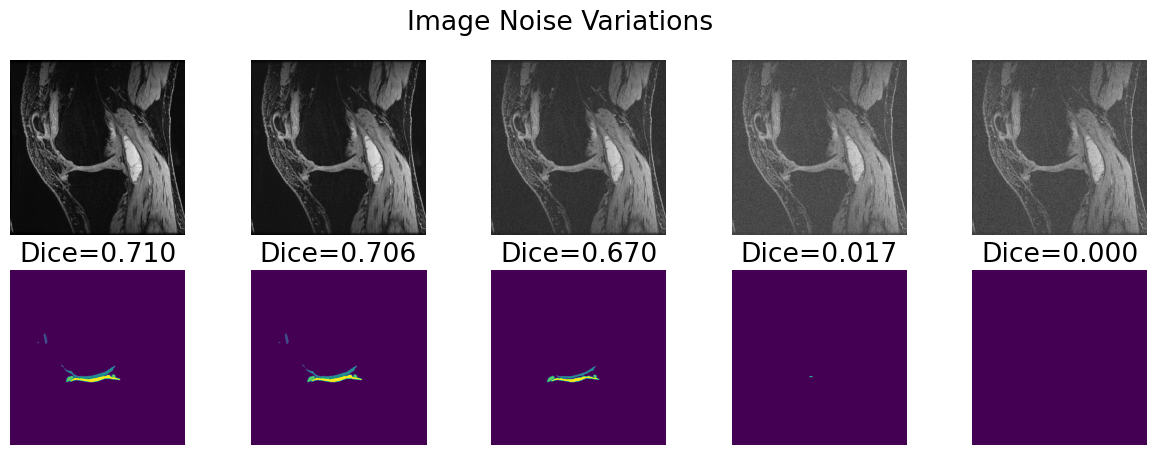

In [ ]:
# Creating Gaussian noise std values
# TODO: Your code here
noise_std_vals = [0,0.01,0.05,0.09,0.1]

# Scaling image to have a max value of 1
# TODO: Your code here
scale_img = echo_img/echo_img.max()

_, axs = plt.subplots(2, len(noise_std_vals), figsize=(15,5))
plt.suptitle(f'Image Noise Variations')

for noise_idx, noise_std in enumerate(noise_std_vals):

    # Creating different amounts of image noise and segment the noisy image
    # TODO: Your code here
    gauss_noise = np.random.normal(0, noise_std, size = scale_img.shape)
    noisy_img = scale_img + gauss_noise
    noisy_seg = segment_slice(noisy_img)
    noisy_dice = compute_dice(gt_seg_cat, noisy_seg)

    # Plotting image + noise
    plt.subplot(2, len(noise_std_vals), noise_idx + 1)
    # TODO: Your code here
    plt.imshow(noisy_img, cmap = 'gray')
    plt.axis('off')

    # Plotting segmentation
    plt.subplot(2, len(noise_std_vals), noise_idx + 1 + len(noise_std_vals))
    # TODO: Your code here
    plt.imshow(noisy_seg, cmap = 'viridis')
    plt.title(f'Dice={noisy_dice:.3f}')
    plt.axis('off')

plt.show()
plt.close()

As the noise increase, we can see that segmentation is less accurate, with dice index lowered to 0 when noise std > 0.1. The experimented noise stds are [0,0.01,0.05,0.09,0.1]. At low noise levels (std = 0.01 or 0.05), we can see that the segmented result still has dice index around 0.7, indicating similar performance to the segmentation on original image. However, for noise with std 0.09 and 0.1, the dice indices lowered to around 0, and hardly any pixels are segmented into one of the 4 categories as seen on the images.